# SESSION 10 : Retrievers in LangChain | Generative AI using LangChain | Video 13

https://youtu.be/pJdMxwXBsk0?list=PLKnIA16_RmvaTbihpo4MtzVm4XOQa0ER0

### What are Retrievers

- A retriever is a component in LangChain that __fetches relevant documents__ from a data source in response to a user’s query. 



- __There are multiple types of retrievers__


- All retrievers in LangChain are runnables


* They are used in **RAG pipelines** (Retrieve → Augment → Generate).


* Input = query string, Output = list of `Document` objects.

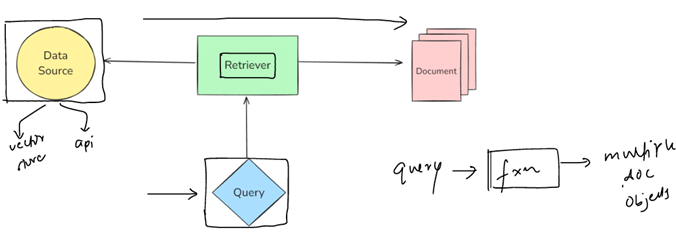

## Types of Retrievers (Document source based) : 

### 1. Wikipedia Retriever

A Wikipedia Retriever is a retriever that queries the Wikipedia API to fetch relevant content for a given query.

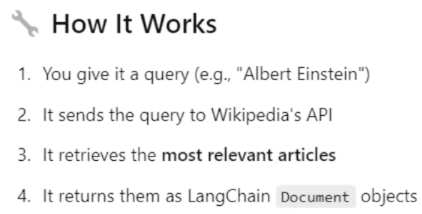

code : https://colab.research.google.com/drive/1vuuIYmJeiRgFHsH-ibH_NUFjtdc5D9P6?usp=sharing

### 2. **VectorStoreRetriever** (most common)


- A Vector Store Retriever in LangChain is the most common type of retriever that lets you search and fetch documents from a vector store based on __semantic similarity using vector embeddings.__

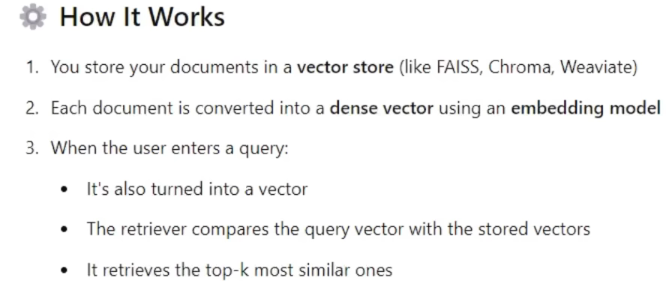

```python
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

docs = ["LangChain is great", "I love pizza", "LLMs are powerful"]
embeddings = OpenAIEmbeddings()
db = FAISS.from_texts(docs, embeddings)

retriever = db.as_retriever(search_kwargs={"k": 2})
print(retriever.invoke("Tell me about LangChain"))
```

## Types of Retrievers (Strategy based) :

### 1. Maximal Marginal Relevance (MMR) -> non-redundant results

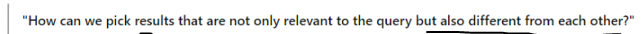

MMR is an information retrieval algorithm designed to reduce redundancy in the retrieved results while maintaining high relevance to the query.



MMR is a **re-ranking technique** used after initial retrieval.

  * You retrieve a set of documents (say top-20) using similarity search.
  * Then MMR tries to select the final `k` documents that **balance relevance with diversity**.
  * It avoids returning documents that are too similar to each other while still keeping them relevant to the query.



* **Where used in LangChain**:
  `vectorstore.max_marginal_relevance_search()` or `MMRRetriever`

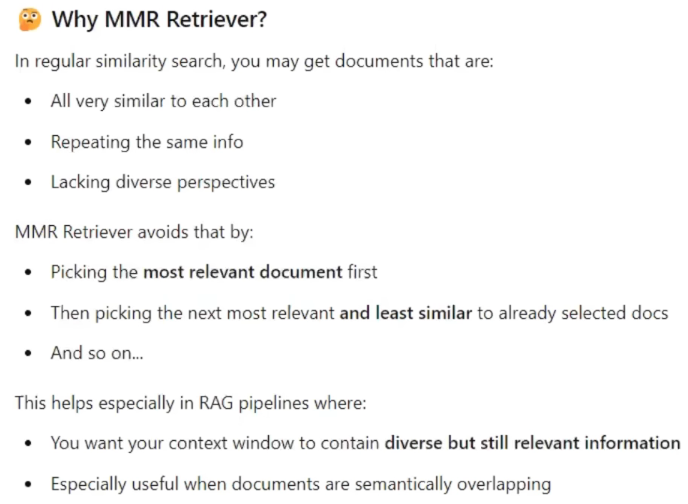


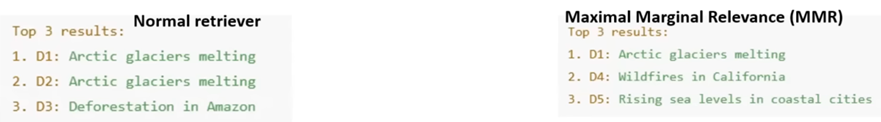

### 🔹 2. **MultiQueryRetriever** -> solves ambiguous queries

* **What it does**:
  
  
Instead of relying on **one query**, MultiQueryRetriever uses an **LLM to generate multiple reformulations of the query**. Expands the query into multiple variations → retrieves more relevant docs.

  * These queries are sent independently to the retriever.
  * Results are merged (often deduplicated).
  * This helps cover **different phrasings** and **angles of the same information need**.

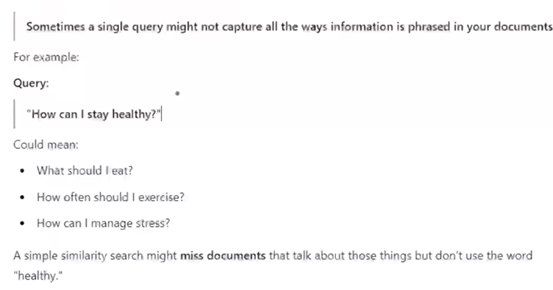

### **Where used in LangChain**:
  
  
  `MultiQueryRetriever.from_llm(retriever=vectorstore.as_retriever(), llm=...)`

* **Example**:
  User query: *"side effects of aspirin"*
  LLM expands into:

  * "What are the risks of taking aspirin?"
  * "Negative impacts of aspirin use"
  * "Adverse reactions to aspirin"
    Each query may retrieve slightly different but complementary docs.


```python
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_openai import ChatOpenAI

retriever = MultiQueryRetriever.from_llm(retriever=db.as_retriever(), llm=ChatOpenAI())
print(retriever.invoke("What is LangChain?"))
```

### Steps in MultiQuery retriever :

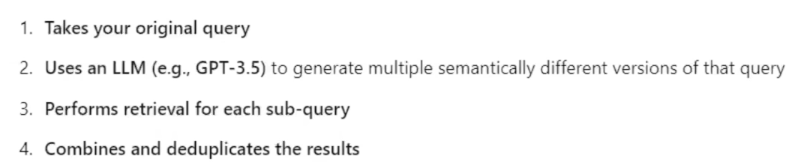

### LLM generates 5 queries from one query : 

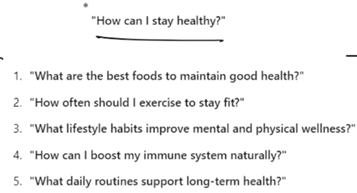

#### will fetch 5 documents per query and give top 2 or 3. will remove any duplicates

### 3. **ContextualCompressionRetriever**

The Contextual Compression Retriever in LangChain is an advanced retriever that improves retrieval quality by compressing documents after retrieval — keeping only the relevant content based on the user's query.

Uses an LLM/compression step to **shrink retrieved docs** to most relevant content.

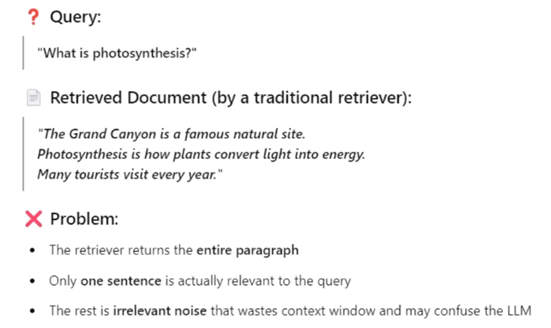

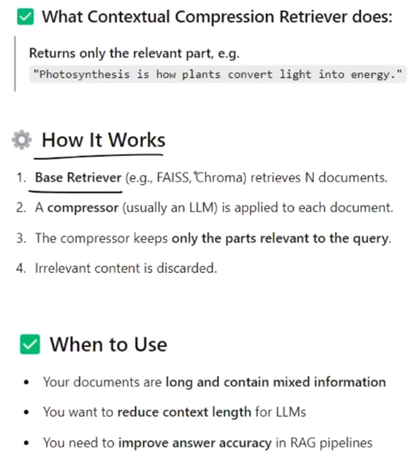

```python
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain_openai import ChatOpenAI

compressor = LLMChainExtractor.from_llm(ChatOpenAI())
compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=db.as_retriever())

print(compression_retriever.invoke("Summarize LangChain"))
```

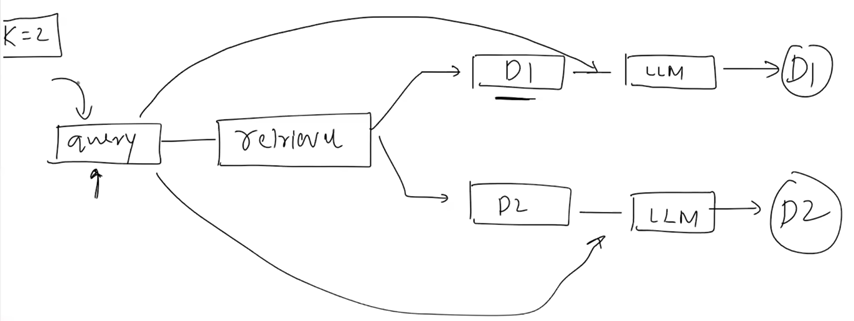

### 4. **ParentDocumentRetriever**

Keeps large parent docs but indexes smaller chunks → returns whole parent.

```python
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=50)
docstore = InMemoryStore()

retriever = ParentDocumentRetriever(
    vectorstore=db, docstore=docstore, child_splitter=splitter
)
```

### 5. **EnsembleRetriever**

Combines multiple retrievers (e.g., vector + keyword) with weights.

```python
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever

bm25 = BM25Retriever.from_texts(docs)
ensemble = EnsembleRetriever(retrievers=[db.as_retriever(), bm25], weights=[0.5, 0.5])

print(ensemble.invoke("LangChain use cases"))
```

### 6. **TimeWeightedVectorStoreRetriever**

Prioritizes documents by **recency + relevance**.

```python
from langchain.retrievers import TimeWeightedVectorStoreRetriever

retriever = TimeWeightedVectorStoreRetriever(vectorstore=db, decay_rate=0.01)
print(retriever.invoke("LangChain"))
```

✅ **In short**:

* **VectorStoreRetriever** → embeddings + similarity search


* **MultiQueryRetriever** → multiple query variations


* **ParentDocumentRetriever** → retrieves parent docs for context


* **EnsembleRetriever** → combines different retrievers


* **TimeWeightedVectorStoreRetriever** → time + relevance aware


* **ContextualCompressionRetriever** → compresses retrieved docs


## More retrievers

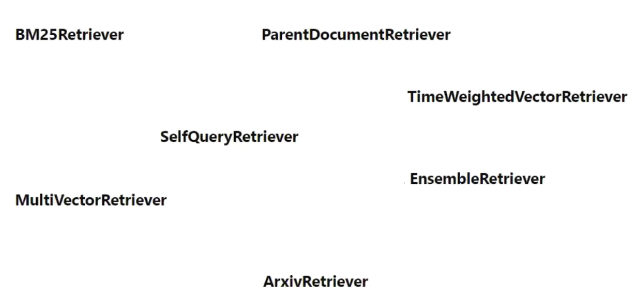